## Figure 17

Similar to [Figure 16](https://github.com/EdwardJKim/astroclass/blob/master/paper/notebooks/figure16/perform_mag_cut.ipynb)
but using $z_{\text{spec}}$ cuts.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('legend', fontsize=10)

In [3]:
truth_train = np.loadtxt('../../data/truth_train.dat')
truth_test = np.loadtxt('../../data/truth_test.dat')

In [4]:
# load base classifiers
mag_cut_str = ['99', '1_6', '1_4', '1_2', '1_0', '0_8', '0_6', '0_4', '0_2']
tpc = [np.loadtxt('../../data/vvds_z_{0}_tpc_test.mlz'.format(i), unpack=True, usecols=(2,)) for i in mag_cut_str]
som = [np.loadtxt('../../data/vvds_z_{0}_som_test.mlz'.format(i), unpack=True, usecols=(2,)) for i in mag_cut_str]
hbc = [np.loadtxt('../../data/vvds_z_{0}_median.hbc'.format(i), unpack=True, usecols=(2,)) for i in mag_cut_str]
hbc = [i[-len(truth_test):] for i in hbc]
bmc = [np.loadtxt('../../data/vvds_z_{0}.bmc'.format(i), unpack=True, usecols=(0,)) for i in mag_cut_str]

In [5]:
def calc_completeness_purity(truth, classif, mag, p_cut=0.5, bins=np.arange(16, 26, 0.5)):
    '''
    '''
    # true galaxies classified as stars
    gs_bin, _ = np.histogram(mag[(classif > p_cut) & (truth == 0)], bins=bins)
    # true galaxies classified as galaxies
    gg_bin, _ = np.histogram(mag[(classif < p_cut) & (truth == 0)], bins=bins)
    # true stars classified as galaxies
    sg_bin, _ = np.histogram(mag[(classif < p_cut) & (truth == 1)], bins=bins)
    # true stars classified as stars
    ss_bin, _ = np.histogram(mag[(classif > p_cut) & (truth == 1)], bins=bins)

    # galaxy completeness
    g_comp_bin = gg_bin / (gg_bin + gs_bin)
    g_comp_bin[~np.isfinite(g_comp_bin)] = 1
    # galaxy purity
    g_pur_bin = gg_bin / (gg_bin + sg_bin)
    g_pur_bin[~np.isfinite(g_pur_bin)] = 1
    # star completeness
    s_comp_bin = ss_bin / (ss_bin + sg_bin)
    s_comp_bin[~np.isfinite(s_comp_bin)] = 1
    # star purity
    s_pur_bin = ss_bin / (ss_bin + gs_bin)
    s_pur_bin[~np.isfinite(s_pur_bin)] = 1
    
    return g_comp_bin, g_pur_bin, s_comp_bin, s_pur_bin

    
def find_purity_at(truth_test, clf, step=0.001, gc=None, sc=None):
    
    try:
        assert bool(gc) != bool(sc)
    except:
        print('Specify one of gc or sc parameter.')

    pbin = np.arange(0, 1, step)
    
    pure_all = np.zeros(len(pbin))
    comp_all = np.zeros(len(pbin))
    
    for i, p in enumerate(pbin):
        
        # true galaxies classified as stars
        gs = ((clf >= p) & (truth_test == 0)).sum()
        # true galaxies classified as galaxies
        gg = ((clf < p) & (truth_test == 0)).sum()
        # true stars classified as galaxies
        sg = ((clf < p) & (truth_test == 1)).sum()
        # true stars classified as stars
        ss = ((clf >= p) & (truth_test == 1)).sum()
    
        if gc is not None:
            if gg == 0 and gg + sg == 0:
                pure_all[i] = 1
            else:
                pure_all[i] = gg / (gg + sg)
            if gg == 0 and gg + gs == 0:
                comp_all[i] = 1
            else:
                comp_all[i] = gg / (gg + gs)
            
        if sc is not None:
            if ss == 0 and ss + sg == 0:
                comp_all[i] = 1
            else:
                comp_all[i] = ss / (ss + sg)
            if ss == 0 and ss + gs == 0:
                pure_all[i] = 1
            else:
                pure_all[i] = ss / (ss + gs)
    
    if gc is not None:
        ibin = np.argmin(np.abs(comp_all - gc))
        return pbin[ibin], pure_all[ibin]
    
    if sc is not None:
        ibin = np.argmin(np.abs(comp_all - sc))
        return pbin[ibin], pure_all[ibin]

In [6]:
from sklearn.metrics import roc_auc_score
tpc_auc = [roc_auc_score(truth_test, i) for i in tpc]
som_auc = [roc_auc_score(truth_test, i) for i in som]
hbc_auc = [roc_auc_score(truth_test, i) for i in hbc]
bmc_auc = [roc_auc_score(truth_test, i) for i in bmc]

In [7]:
from sklearn.metrics import mean_squared_error
tpc_mse = [mean_squared_error(truth_test, i) for i in tpc]
som_mse = [mean_squared_error(truth_test, i) for i in som]
hbc_mse = [mean_squared_error(truth_test, i[-len(truth_test):]) for i in hbc]
bmc_mse = [mean_squared_error(truth_test, i) for i in bmc]

In [8]:
def find_gal_pur(truth, clf, gc=0.9964, step=0.001):
    result = []
    for k in clf:
        _, j = find_purity_at(truth, k, gc=gc, step=step)
        result += [j] 
    return result

In [9]:
tpc_gpur = find_gal_pur(truth_test, tpc)

In [10]:
bmc_gpur= find_gal_pur(truth_test, bmc)

In [11]:
hbc_gpur= find_gal_pur(truth_test, hbc)

In [12]:
som_gpur= find_gal_pur(truth_test, som)

In [13]:
def find_star_pur(truth, clf, sc=0.7145, step=0.001):
    result = []
    for k in clf:
        _, j = find_purity_at(truth, k, sc=sc, step=step)
        result += [j]
    return result

In [14]:
tpc_spur = find_star_pur(truth_test, tpc)

In [15]:
bmc_spur = find_star_pur(truth_test, bmc)

In [16]:
hbc_spur = find_star_pur(truth_test, hbc)

In [17]:
som_spur = find_star_pur(truth_test, som)

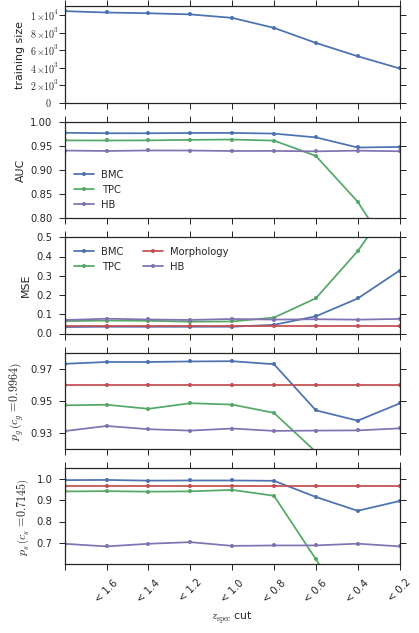

In [23]:
p = sns.color_palette()
sns.set_style("ticks")

fig = plt.figure(figsize=(6, 10))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=3)
ax3 = plt.subplot2grid((5, 3), (2, 0), colspan=3)
ax4 = plt.subplot2grid((5, 3), (3, 0), colspan=3)
ax5 = plt.subplot2grid((5, 3), (4, 0), colspan=3)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), rotation=45)

ax1.plot([10456, 10304, 10216, 10086, 9690, 8547, 6828, 5300, 3912], ls='-', marker='o', markersize=4)
ax1.set_ylabel('training size')
ax1.set_yticks([0, 2000, 4000, 6000, 8000, 10000])
ax1.set_yticklabels([r'$0$', r'$2 \times 10^3$', r'$4 \times 10^3$', r'$6 \times 10^3$', r'$8 \times 10^3$',
                     r'$1 \times 10^4$'])
ax1.legend(loc='upper right')
for ticks in ax1.get_yaxis().majorTicks[1:]:
    ticks.set_pad(0)

ax2.plot(bmc_auc, label='BMC',
         color=p[0], ls='-', marker='o', markersize=4)
ax2.plot(tpc_auc, label='TPC',
         color=p[1], ls='-', marker='o', markersize=4)
ax2.plot(hbc_auc, label='HB',
         color=p[3], ls='-', marker='o', markersize=4)
ax2.set_ylim(0.8, 1.0)
ax2.legend(loc='lower left')
#ax2.set_yticks([0.94, 0.95, 0.96, 0.97])
ax2.set_ylabel('AUC')

ax3.plot(bmc_mse, label='BMC',
         color=p[0], ls='-', marker='o', markersize=4)
ax3.plot(tpc_mse, label='TPC',
         color=p[1], ls='-', marker='o', markersize=4)
ax3.plot([0.0397] * len(tpc_mse),
         color=p[2], label='Morphology', ls='-', marker='o', markersize=4)
ax3.plot(hbc_mse, label='HB',
         color=p[3], ls='-', marker='o', markersize=4)
ax3.set_ylim(0, 0.5)
ax3.set_yticks(np.arange(0, 0.6, 0.1))
ax3.set_ylabel('MSE')
ax3.legend(loc='upper left', ncol=2)

ax4.plot(bmc_gpur, label='BMC',
         color=p[0], ls='-', marker='o', markersize=4)
ax4.plot(tpc_gpur, label='TPC',
         color=p[1], ls='-', marker='o', markersize=4)
ax4.plot([0.9597] * len(tpc_gpur),
         color=p[2], label='Morphology', marker='o', markersize=4)
ax4.plot(hbc_gpur, label='HB',
         color=p[3], ls='-', marker='o', markersize=4)
ax4.set_ylim(0.92, 0.98)
ax4.set_yticks([0.93, 0.95, 0.97])
ax4.set_ylabel(r'$p_g\left(c_g=0.9964\right)$', fontsize=12)

ax5.plot(bmc_spur, label='BMC',
         color=p[0], ls='-', marker='o', markersize=4)
ax5.plot(tpc_spur, label='TPC',
         color=p[1], ls='-', marker='o', markersize=4)
ax5.plot([0.9666] * len(tpc_spur),
         color=p[2], label='Morphology', ls='-', marker='o', markersize=4)
ax5.plot(hbc_spur, label='HB',
         color=p[3], ls='-', marker='o', markersize=4)
ax5.set_ylim(0.6, 1.05)
ax5.set_yticks([0.7, 0.8, 0.9, 1.0])
ax5.set_ylabel(r'$p_s\left(c_s=0.7145\right)$', fontsize=12)

ax5.set_xticklabels(['', '< 1.6', '< 1.4', '< 1.2', '< 1.0', '< 0.8', '< 0.6', '< 0.4', '< 0.2'])
ax5.set_xlabel(r'$z_{\mathrm{spec}}$ cut')

plt.savefig('../../figures/perform_z_cut.pdf')
plt.show()